In [108]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime

In [109]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

JSON_PATH = Path("../data/anilist_top10000.json")
JSON_PATH

PosixPath('../data/anilist_top10000.json')

In [110]:
# JSON -> DataFrame
if not JSON_PATH.exists():
    raise FileNotFoundError("JSON 파일 없음!")

with JSON_PATH.open("r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)
df.head()

,id,title,format,status,season,seasonYear,seasonInt,startDate,endDate,episodes,duration,averageScore,meanScore,popularity,favourites,genres,tags,stats,studios,staff
0,16498,"{'romaji': 'Shingeki no Kyojin', 'english': 'A...",TV,FINISHED,SPRING,2013.0,132.0,"{'year': 2013, 'month': 4, 'day': 7}","{'year': 2013, 'month': 9, 'day': 28}",25.0,24.0,85.0,85.0,923138,55763,"[Action, Drama, Fantasy, Mystery]","[{'name': 'Kaiju'}, {'name': 'Revenge'}, {'nam...","{'scoreDistribution': [{'score': 10, 'amount':...","{'nodes': [{'name': 'WIT STUDIO'}, {'name': 'P...","{'nodes': [{'name': {'full': 'Yuu Kobayashi'},..."
1,101922,"{'romaji': 'Kimetsu no Yaiba', 'english': 'Dem...",TV,FINISHED,SPRING,2019.0,192.0,"{'year': 2019, 'month': 4, 'day': 6}","{'year': 2019, 'month': 9, 'day': 28}",26.0,24.0,82.0,82.0,876899,42077,"[Action, Adventure, Drama, Fantasy, Supernatural]","[{'name': 'Demons'}, {'name': 'Shounen'}, {'na...","{'scoreDistribution': [{'score': 10, 'amount':...","{'nodes': [{'name': 'ufotable'}, {'name': 'Ani...","{'nodes': [{'name': {'full': 'Steve Staley'}, ..."
2,1535,"{'romaji': 'DEATH NOTE', 'english': 'Death Not...",TV,FINISHED,FALL,2006.0,64.0,"{'year': 2006, 'month': 10, 'day': 4}","{'year': 2007, 'month': 6, 'day': 27}",37.0,23.0,84.0,84.0,840763,44158,"[Mystery, Psychological, Supernatural, Thriller]","[{'name': 'Crime'}, {'name': 'Detective'}, {'n...","{'scoreDistribution': [{'score': 10, 'amount':...","{'nodes': [{'name': 'MADHOUSE'}, {'name': 'VAP...","{'nodes': [{'name': {'full': 'Aya Hirano'}, 'p..."
3,113415,"{'romaji': 'Jujutsu Kaisen', 'english': 'JUJUT...",TV,FINISHED,FALL,2020.0,204.0,"{'year': 2020, 'month': 10, 'day': 3}","{'year': 2021, 'month': 3, 'day': 27}",24.0,24.0,84.0,84.0,831794,49308,"[Action, Drama, Supernatural]","[{'name': 'Urban Fantasy'}, {'name': 'Shounen'...","{'scoreDistribution': [{'score': 10, 'amount':...","{'nodes': [{'name': 'Toho'}, {'name': 'MAPPA'}...",{'nodes': [{'name': {'full': 'Michael Sorich'}...
4,21459,"{'romaji': 'Boku no Hero Academia', 'english':...",TV,FINISHED,SPRING,2016.0,162.0,"{'year': 2016, 'month': 4, 'day': 3}","{'year': 2016, 'month': 6, 'day': 26}",13.0,24.0,76.0,76.0,777901,20699,"[Action, Adventure, Comedy]","[{'name': 'Super Power'}, {'name': 'Superhero'...","{'scoreDistribution': [{'score': 10, 'amount':...","{'nodes': [{'name': 'bones'}, {'name': 'Dentsu...","{'nodes': [{'name': {'full': 'Justin Cook'}, '..."


In [111]:
# title 정규화
df["title_romaji"] = df["title"].apply(lambda x: (x or {}).get("romaji"))
df["title_english"] = df["title"].apply(lambda x: (x or {}).get("english"))
df["title_native"] = df["title"].apply(lambda x: (x or {}).get("native"))

In [112]:
df[["id","title_romaji","title_english","title_native"]].head()

,id,title_romaji,title_english,title_native
0,16498,Shingeki no Kyojin,Attack on Titan,進撃の巨人
1,101922,Kimetsu no Yaiba,Demon Slayer: Kimetsu no Yaiba,鬼滅の刃
2,1535,DEATH NOTE,Death Note,DEATH NOTE
3,113415,Jujutsu Kaisen,JUJUTSU KAISEN,呪術廻戦
4,21459,Boku no Hero Academia,My Hero Academia,僕のヒーローアカデミア


In [113]:
# tags -> name 리스트로 정리
# tags: list[{name: ...}, ...] 형태니까, name만 빼온다
def extract_tag_names(tag_list):
    if not isinstance(tag_list, list):
        return []
    return [t.get("name") for t in tag_list if isinstance(t, dict)]

df["tag_list"] = df["tags"].apply(extract_tag_names)
df["tag_list"].head()

0    [Kaiju, Revenge, Military, Tragedy, Post-Apoca...
1    [Demons, Shounen, Swordplay, Male Protagonist,...
2    [Crime, Detective, Anti-Hero, Male Protagonist...
3    [Urban Fantasy, Shounen, Youkai, Super Power, ...
4    [Super Power, Superhero, Shounen, Primarily Te...
Name: tag_list, dtype: object

In [114]:
# genres는 OHE(OneHot Encoding)하면 좋을듯?
df_genre = df[["id", "genres"]].explode("genres")
df_genre = df_genre.dropna(subset=["genres"])

genre_counts = df_genre["genres"].value_counts()
genre_counts

genres
Comedy           4452
Action           3725
Fantasy          2785
Drama            2525
Adventure        2412
Sci-Fi           2172
Romance          2095
Slice of Life    1831
Supernatural     1443
Ecchi             866
Mecha             863
Mystery           781
Sports            591
Music             533
Psychological     482
Horror            389
Mahou Shoujo      334
Thriller          200
Name: count, dtype: int64

In [115]:
df_genre_ohe = pd.get_dummies(df_genre["genres"], prefix="genre")
df_genre_ohe = pd.concat([df_genre[["id"]], df_genre_ohe], axis=1)
df_genre_ohe = df_genre_ohe.groupby("id", as_index=False).sum()

df_genre_ohe.head()

,id,genre_Action,genre_Adventure,genre_Comedy,genre_Drama,genre_Ecchi,genre_Fantasy,genre_Horror,genre_Mahou Shoujo,genre_Mecha,genre_Music,genre_Mystery,genre_Psychological,genre_Romance,genre_Sci-Fi,genre_Slice of Life,genre_Sports,genre_Supernatural,genre_Thriller
0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,5,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
2,6,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,7,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,8,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [116]:
# tags도 OHE
df_tag = df[["id", "tag_list"]].explode("tag_list")
df_tag = df_tag.dropna(subset=["tag_list"])

tag_counts = df_tag["tag_list"].value_counts()
tag_counts

tag_list
Male Protagonist         3826
Female Protagonist       3325
School                   2369
Primarily Female Cast    1893
Shounen                  1815
                         ... 
Sweat                       1
4-koma                      1
Irrumatio                   1
Futanari                    1
Defloration                 1
Name: count, Length: 391, dtype: int64

In [117]:
# tags는 Top200만 쓰자
TOP_N_TAGS = 200
top_tags = tag_counts.head(TOP_N_TAGS).index.tolist()

df_tag_filtered = df_tag[df_tag["tag_list"].isin(top_tags)]

In [118]:
df_tag_ohe = pd.get_dummies(df_tag_filtered["tag_list"], prefix="tag")
df_tag_ohe = pd.concat([df_tag_filtered[["id"]], df_tag_ohe], axis=1)
df_tag_ohe = df_tag_ohe.groupby("id", as_index=False).sum()

df_tag_ohe.head()

,id,tag_Achronological Order,tag_Acting,tag_Adoption,tag_Advertisement,tag_Afterlife,tag_Age Gap,tag_Age Regression,tag_Aliens,tag_Alternate Universe,tag_Amnesia,tag_Anachronism,tag_Angels,tag_Animals,tag_Anthropomorphism,tag_Anti-Hero,tag_Archery,tag_Artificial Intelligence,tag_Assassins,tag_Athletics,tag_Aviation,tag_Band,tag_Baseball,tag_Battle Royale,tag_Bisexual,tag_Body Horror,tag_Body Swapping,tag_Boys' Love,tag_Bullying,tag_CGI,tag_Card Battle,tag_Cars,tag_Chibi,tag_Chuunibyou,tag_Class Struggle,tag_Classic Literature,tag_Clone,tag_Coastal,tag_Cohabitation,tag_College,tag_Coming of Age,tag_Conspiracy,tag_Cosmic Horror,tag_Crime,tag_Crossdressing,tag_Crossover,tag_Cult,tag_Cultivation,tag_Curses,tag_Cute Boys Doing Cute Things,tag_Cute Girls Doing Cute Things,tag_Cyberpunk,tag_Cyborg,tag_Dancing,tag_Delinquents,tag_Demons,tag_Denpa,tag_Desert,tag_Detective,tag_Disability,tag_Dissociative Identities,tag_Dragons,tag_Drawing,tag_Drugs,tag_Dungeon,tag_Dystopian,tag_Educational,tag_Elf,tag_Ensemble Cast,tag_Environmental,tag_Episodic,tag_Espionage,tag_Fairy,tag_Fairy Tale,tag_Family Life,tag_Female Harem,tag_Female Protagonist,tag_Femboy,tag_Food,tag_Foreign,tag_Found Family,tag_Fugitive,tag_Full CGI,tag_Gangs,tag_Gender Bending,tag_Ghost,tag_Gods,tag_Gore,tag_Guns,tag_Gyaru,tag_Henshin,tag_Heterosexual,tag_Hikikomori,tag_Historical,tag_Idol,tag_Incest,tag_Isekai,tag_Iyashikei,tag_Josei,tag_Kaiju,tag_Kemonomimi,tag_Kids,tag_Kuudere,tag_LGBTQ+ Themes,tag_Language Barrier,tag_Lost Civilization,tag_Love Triangle,tag_Magic,tag_Maids,tag_Male Harem,tag_Male Protagonist,tag_Marriage,tag_Martial Arts,tag_Medieval,tag_Memory Manipulation,tag_Meta,tag_Military,tag_Monster Girl,tag_Motorcycles,tag_Musical Theater,tag_Mythology,tag_Nekomimi,tag_Ninja,tag_No Dialogue,tag_Nudity,tag_Ojou-sama,tag_Orphan,tag_Otaku Culture,tag_Outdoor Activities,tag_Parody,tag_Philosophy,tag_Pirates,tag_Police,tag_Politics,tag_Post-Apocalyptic,tag_Primarily Adult Cast,tag_Primarily Child Cast,tag_Primarily Female Cast,tag_Primarily Male Cast,tag_Primarily Teen Cast,tag_Proxy Battle,tag_Rape,tag_Real Robot,tag_Rehabilitation,tag_Reincarnation,tag_Religion,tag_Revenge,tag_Robots,tag_Royal Affairs,tag_Rural,tag_Samurai,tag_Satire,tag_School,tag_School Club,tag_Seinen,tag_Shapeshifting,tag_Ships,tag_Shoujo,tag_Shounen,tag_Shrine Maiden,tag_Slapstick,tag_Slavery,tag_Snowscape,tag_Space,tag_Space Opera,tag_Spearplay,tag_Steampunk,tag_Suicide,tag_Super Power,tag_Super Robot,tag_Superhero,tag_Surreal Comedy,tag_Survival,tag_Swordplay,tag_Tanned Skin,tag_Teacher,tag_Terrorism,tag_Time Manipulation,tag_Time Skip,tag_Tokusatsu,tag_Tomboy,tag_Tragedy,tag_Trains,tag_Transgender,tag_Travel,tag_Tsundere,tag_Twins,tag_Unrequited Love,tag_Urban,tag_Urban Fantasy,tag_Vampire,tag_Video Games,tag_Virtual World,tag_War,tag_Witch,tag_Work,tag_Yakuza,tag_Yandere,tag_Youkai,tag_Yuri,tag_Zombie
0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,6,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0

In [119]:
# studios는 개많으니까, OHE 안하는게 나을듯
# 하는게 더 유의미할 수도 ?
def extract_studio_names(studio_obj):
    if not isinstance(studio_obj, dict):
        return []
    return [n.get("name") for n in (studio_obj.get("nodes") or []) if isinstance(n, dict)]

df["studios_list"] = df["studios"].apply(extract_studio_names)
df[["id", "studios_list"]].head()

,id,studios_list
0,16498,"[WIT STUDIO, Pony Canyon, Kodansha, Production..."
1,101922,"[ufotable, Aniplex, Shueisha, Aniplex of Ameri..."
2,1535,"[MADHOUSE, VAP, Viz Media, Nippon Television N..."
3,113415,"[Toho, MAPPA, Shueisha, Sumzap, Mainichi Broad..."
4,21459,"[bones, Dentsu, Mainichi Broadcasting System, ..."


# stats column
- stats 필드에서, scoreDistribution, statusDistribution를 활용하기 위해 **stats_weighted_score, stats_drop_rate** 컬럼을 새로 정의함.

## stats_weighted_score
```python
stats = {
  "scoreDistribution": [
      {"score": 10, "amount": 5321},
      {"score": 9, "amount": 7810},
      {"score": 8, "amount": 10011},
      ...
  ]
}
```
-> `weighted_score = Σ(score * amount) / Σ(amount)`

## stats_drop_rate
```python
stats = {
  "statusDistribution": [
      {"status": "completed", "amount": ...},
      {"status": "watching", "amount": ...},
      {"status": "dropped",  "amount": ...},
      {"status": "paused",   "amount": ...},
      ...
  ]
}
```

-> `drop_rate = dropped / total_users`

In [120]:
def get_weighted_score(stats_obj):
    if not isinstance(stats_obj, dict):
        return None
    dist = stats_obj.get("scoreDistribution") or []
    total = 0
    count = 0
    for item in dist:
        score = item.get("score")
        amount = item.get("amount", 0)
        total += score * amount
        count += amount
    return total / count if count > 0 else None


def get_drop_rate(stats_obj):
    if not isinstance(stats_obj, dict):
        return None
    dist = stats_obj.get("statusDistribution") or []

    total = 0
    dropped = 0
    for item in dist:
        status = item.get("status")
        amount = item.get("amount", 0)
        total += amount
        if status == "DROPPED":
            dropped = amount
    return dropped / total if total > 0 else None

In [121]:
df["stats_weighted_score"] = df["stats"].apply(get_weighted_score)
df["stats_drop_rate"] = df["stats"].apply(get_drop_rate)

In [122]:
def get_main_studio(studios_obj):
    """
    AniList studios 필드에서 isMain == True 인 스튜디오 이름 하나를 반환.
    없으면 None.
    studios_obj 예시:
    {
      "nodes": [{"name": "WIT STUDIO"}, {"name": "Pony Canyon"}, ...],
      "edges": [{"isMain": true}, {"isMain": false}, ...]
    }
    """
    if not isinstance(studios_obj, dict):
        return None
    
    nodes = studios_obj.get("nodes") or []
    edges = studios_obj.get("edges") or []
    
    for node, edge in zip(nodes, edges):
        if isinstance(edge, dict) and edge.get("isMain"):
            if isinstance(node, dict):
                return node.get("name")
    return None


def get_studios_list(studios_obj):
    """
    그냥 참고용: 모든 스튜디오 이름을 리스트 형태로 뽑고 싶을 때.
    나중에 필요 없으면 안 써도 됨.
    """
    if not isinstance(studios_obj, dict):
        return []
    nodes = studios_obj.get("nodes") or []
    return [n.get("name") for n in nodes if isinstance(n, dict) and n.get("name")]

In [123]:
df["main_studio"] = df["studios"].apply(get_main_studio)
df["studios_list"] = df["studios"].apply(get_studios_list)

df[["title_romaji", "main_studio", "studios_list"]].head()

,title_romaji,main_studio,studios_list
0,Shingeki no Kyojin,WIT STUDIO,"[WIT STUDIO, Pony Canyon, Kodansha, Production..."
1,Kimetsu no Yaiba,ufotable,"[ufotable, Aniplex, Shueisha, Aniplex of Ameri..."
2,DEATH NOTE,MADHOUSE,"[MADHOUSE, VAP, Viz Media, Nippon Television N..."
3,Jujutsu Kaisen,MAPPA,"[Toho, MAPPA, Shueisha, Sumzap, Mainichi Broad..."
4,Boku no Hero Academia,bones,"[bones, Dentsu, Mainichi Broadcasting System, ..."


In [124]:
# 빠졌던 startDate, endDate, stats 데이터 프레임에 추가
df["start_year"] = df["startDate"].apply(lambda d: (d or {}).get("year"))
df["start_month"] = df["startDate"].apply(lambda d: (d or {}).get("month"))
df["start_day"] = df["startDate"].apply(lambda d: (d or {}).get("day"))

df["end_year"] = df["endDate"].apply(lambda d: (d or {}).get("year"))
df["end_month"] = df["endDate"].apply(lambda d: (d or {}).get("month"))
df["end_day"] = df["endDate"].apply(lambda d: (d or {}).get("day"))

In [125]:
def safe_date(d):
    """
    AniList FuzzyDate {year, month, day} -> datetime.date 로 변환.
    year, month 없으면 None.
    day가 None이면 1일로 가정.
    """
    if not isinstance(d, dict):
        return None
    
    y = d.get("year")
    m = d.get("month")
    day = d.get("day") or 1

    if y and m:
        try:
            return datetime.date(y, m, day)
        except ValueError:
            # 말도 안 되는 날짜면 1일로 다시 시도
            try:
                return datetime.date(y, m, 1)
            except Exception:
                return None
    return None


def airing_days_finished(start_d, end_d, status):
    """
    FINISHED 작품에 대해서만 방영기간(일수) 계산.
    그 외 상태는 None 반환.
    """
    if status != "FINISHED":
        return None
    
    s = safe_date(start_d)
    e = safe_date(end_d)

    if s and e:
        delta = (e - s).days
        return delta if delta >= 0 else None
    return None

In [126]:
df["airing_days"] = df.apply(
    lambda row: airing_days_finished(
        row.get("startDate"),
        row.get("endDate"),
        row.get("status"),
    ),
    axis=1,
)

df[["title_romaji", "status", "airing_days"]].head()

,title_romaji,status,airing_days
0,Shingeki no Kyojin,FINISHED,174.0
1,Kimetsu no Yaiba,FINISHED,175.0
2,DEATH NOTE,FINISHED,266.0
3,Jujutsu Kaisen,FINISHED,175.0
4,Boku no Hero Academia,FINISHED,84.0


In [127]:
df["start_dt"] = pd.to_datetime(
    df["start_year"].astype("Int64").astype(str) + "-" +
    df["start_month"].astype("Int64").astype(str) + "-" +
    df["start_day"].astype("Int64").astype(str),
    errors="coerce"
)

df["end_dt"] = pd.to_datetime(
    df["end_year"].astype("Int64").astype(str) + "-" +
    df["end_month"].astype("Int64").astype(str) + "-" +
    df["end_day"].astype("Int64").astype(str),
    errors="coerce"
)

In [128]:
df["tag_count"] = df["tag_list"].apply(lambda x: len(x))
df["genre_count"] = df["genres"].apply(lambda x: len(x))

In [129]:
drop_cols = ["title", "tags", "studios", "staff"]

df_base = df.drop(columns=[c for c in drop_cols if c in df.columns])

df_final = (
    df_base
    .merge(df_genre_ohe, on="id", how="left")
    .merge(df_tag_ohe, on="id", how="left")
)

df_final.head()

,id,format,status,season,seasonYear,seasonInt,startDate,endDate,episodes,duration,averageScore,meanScore,popularity,favourites,genres,stats,title_romaji,title_english,title_native,tag_list,studios_list,stats_weighted_score,stats_drop_rate,main_studio,start_year,start_month,start_day,end_year,end_month,end_day,airing_days,start_dt,end_dt,tag_count,genre_count,genre_Action,genre_Adventure,genre_Comedy,genre_Drama,genre_Ecchi,genre_Fantasy,genre_Horror,genre_Mahou Shoujo,genre_Mecha,genre_Music,genre_Mystery,genre_Psychological,genre_Romance,genre_Sci-Fi,genre_Slice of Life,genre_Sports,genre_Supernatural,genre_Thriller,tag_Achronological Order,tag_Acting,tag_Adoption,tag_Advertisement,tag_Afterlife,tag_Age Gap,tag_Age Regression,tag_Aliens,tag_Alternate Universe,tag_Amnesia,tag_Anachronism,tag_Angels,tag_Animals,tag_Anthropomorphism,tag_Anti-Hero,tag_Archery,tag_Artificial Intelligence,tag_Assassins,tag_Athletics,tag_Aviation,tag_Band,tag_Baseball,tag_Battle Royale,tag_Bisexual,tag_Body Horror,tag_Body Swapping,tag_Boys' Love,tag_Bullying,tag_CGI,tag_Card Battle,tag_Cars,tag_Chibi,tag_Chuunibyou,tag_Class Struggle,tag_Classic Literature,tag_Clone,tag_Coastal,tag_Cohabitation,tag_College,tag_Coming of Age,tag_Conspiracy,tag_Cosmic Horror,tag_Crime,tag_Crossdressing,tag_Crossover,tag_Cult,tag_Cultivation,tag_Curses,tag_Cute Boys Doing Cute Things,tag_Cute Girls Doing Cute Things,tag_Cyberpunk,tag_Cyborg,tag_Dancing,tag_Delinquents,tag_Demons,tag_Denpa,tag_Desert,tag_Detective,tag_Disability,tag_Dissociative Identities,tag_Dragons,tag_Drawing,tag_Drugs,tag_Dungeon,tag_Dystopian,tag_Educational,tag_Elf,tag_Ensemble Cast,tag_Environmental,tag_Episodic,tag_Espionage,tag_Fairy,tag_Fairy Tale,tag_Family Life,tag_Female Harem,tag_Female Protagonist,tag_Femboy,tag_Food,tag_Foreign,tag_Found Family,tag_Fugitive,tag_Full CGI,tag_Gangs,tag_Gender Bending,tag_Ghost,tag_Gods,tag_Gore,tag_Guns,tag_Gyaru,tag_Henshin,tag_Heterosexual,tag_Hikikomori,tag_Historical,tag_Idol,tag_Incest,tag_Isekai,tag_Iyashikei,tag_Josei,tag_Kaiju,tag_Kemonomimi,tag_Kids,tag_Kuudere,tag_LGBTQ+ Themes,tag_Language Barrier,tag_Lost Civilization,tag_Love Triangle,tag_Magic,tag_Maids,tag_Male Harem,tag_Male Protagonist,tag_Marriage,tag_Martial Arts,tag_Medieval,tag_Memory Manipulation,tag_Meta,tag_Military,tag_Monster Girl,tag_Motorcycles,tag_Musical Theater,tag_Mythology,tag_Nekomimi,tag_Ninja,tag_No Dialogue,tag_Nudity,tag_Ojou-sama,tag_Orphan,tag_Otaku Culture,tag_Outdoor Activities,tag_Parody,tag_Philosophy,tag_Pirates,tag_Police,tag_Politics,tag_Post-Apocalyptic,tag_Primarily Adult Cast,tag_Primarily Child Cast,tag_Primarily Female Cast,tag_Primarily Male Cast,tag_Primarily Teen Cast,tag_Proxy Battle,tag_Rape,tag_Real Robot,tag_Rehabilitation,tag_Reincarnation,tag_Religion,tag_Revenge,tag_Robots,tag_Royal Affairs,tag_Rural,tag_Samurai,tag_Satire,tag_School,tag_School Club,tag_Seinen,tag_Shapeshifting,tag_Ships,tag_Shoujo,tag_Shounen,tag_Shrine Maiden,tag_Slapstick,tag_Slavery,tag_Snowscape,tag_Space,tag_Space Opera,tag_Spearplay,tag_Steampunk,tag_Suicide,tag_Super Power,tag_Super Robot,tag_Superhero,tag_Surreal Comedy,tag_Survival,tag_Swordplay,tag_Tanned Skin,tag_Teacher,tag_Terrorism,tag_Time Manipulation,tag_Time Skip,tag_Tokusatsu,tag_Tomboy,tag_Tragedy,tag_Trains,tag_Transgender,tag_Travel,tag_Tsundere,tag_Twins,tag_Unrequited Love,tag_Urban,tag_Urban Fantasy,tag_Vampire,tag_Video Games,tag_Virtual World,tag_War,tag_Witch,tag_Work,tag_Yakuza,tag_Yandere,tag_Youkai,tag_Yuri,tag_Zombie
0,16498,TV,FINISHED,SPRING,2013.0,132.0,"{'year': 2013, 'month': 4, 'day': 7}","{'year': 2013, 'month': 9, 'day': 28}",25.0,24.0,85.0,85.0,923138,55763,"[Action, Drama, Fantasy, Mystery]","{'scoreDistribution': [{'score': 10, 'amount':...",Shingeki no Kyojin,Attack on Titan,進撃の巨人,"[Kaiju, Revenge, Military, Tragedy, Post-Apoca...","[WIT STUDIO, Pony Canyon, Kodansha, Production...",86.165641,0.015961,WIT STUDIO,2013.0,4.0,7.0,2013.0,9.0,28.0,174.0,2013-04-07,2013-09-28,31,4,1.0,0.0

# 애니 데이터 전처리 완료
- df_fianl : 전체 데이터셋
- df_eda : OHE 제거된 데이터셋
- df_clean_eda : OHE 제거되며, 중복 개념 제거된 데이터셋

### 점수가 아닌 수치 컬럼: 날짜, 에피소드 수, 인기도/즐겨찾기 등
```python
INT_COLS = [
    "start_year", "start_month", "start_day",
    "end_year", "end_month", "end_day",
    "airing_days", "seasonYear", "seasonInt",
    "episodes", "duration",
    "popularity", "favourites",
]
```

### 점수/비율 계열 컬럼: 소수 유지
```python
SCORE_COLS = [
    "stats_weighted_score",
    "stats_drop_rate",
    "averageScore",
    "meanScore",
]
```

### 정수형이지만 지표로도 쓰이는 카운트 계열
```python
COUNT_COLS = [
    "popularity",
    "favourites",
    "episodes",
    "duration",
]
```

### 상관분석 등에 사용할 전체 수치 컬럼 세트
```python
NUMERIC_COLS = SCORE_COLS + COUNT_COLS
```


In [130]:
# 컬럼 순서 바꾸기
# status 컬럼 위치 구하기
cols = list(df_final.columns)
idx = cols.index("status")

# 우리가 status 다음에 넣고 싶은 컬럼 리스트
new_cols = [
    "start_year", "start_month", "start_day",
    "end_year", "end_month", "end_day",
    "airing_days"
]

# 혹시 기존 df에 없거나 중복되면 문제 생기므로 필터링
new_cols = [c for c in new_cols if c in df_final.columns]

# 기존 위치에서 제거
for c in new_cols:
    if c in cols:
        cols.remove(c)

# status 뒤에 순서대로 삽입
for i, c in enumerate(new_cols):
    cols.insert(idx + 1 + i, c)

# 새 순서로 재배치
df_final = df_final[cols]
df_final.head()

,id,format,status,start_year,start_month,start_day,end_year,end_month,end_day,airing_days,season,seasonYear,seasonInt,startDate,endDate,episodes,duration,averageScore,meanScore,popularity,favourites,genres,stats,title_romaji,title_english,title_native,tag_list,studios_list,stats_weighted_score,stats_drop_rate,main_studio,start_dt,end_dt,tag_count,genre_count,genre_Action,genre_Adventure,genre_Comedy,genre_Drama,genre_Ecchi,genre_Fantasy,genre_Horror,genre_Mahou Shoujo,genre_Mecha,genre_Music,genre_Mystery,genre_Psychological,genre_Romance,genre_Sci-Fi,genre_Slice of Life,genre_Sports,genre_Supernatural,genre_Thriller,tag_Achronological Order,tag_Acting,tag_Adoption,tag_Advertisement,tag_Afterlife,tag_Age Gap,tag_Age Regression,tag_Aliens,tag_Alternate Universe,tag_Amnesia,tag_Anachronism,tag_Angels,tag_Animals,tag_Anthropomorphism,tag_Anti-Hero,tag_Archery,tag_Artificial Intelligence,tag_Assassins,tag_Athletics,tag_Aviation,tag_Band,tag_Baseball,tag_Battle Royale,tag_Bisexual,tag_Body Horror,tag_Body Swapping,tag_Boys' Love,tag_Bullying,tag_CGI,tag_Card Battle,tag_Cars,tag_Chibi,tag_Chuunibyou,tag_Class Struggle,tag_Classic Literature,tag_Clone,tag_Coastal,tag_Cohabitation,tag_College,tag_Coming of Age,tag_Conspiracy,tag_Cosmic Horror,tag_Crime,tag_Crossdressing,tag_Crossover,tag_Cult,tag_Cultivation,tag_Curses,tag_Cute Boys Doing Cute Things,tag_Cute Girls Doing Cute Things,tag_Cyberpunk,tag_Cyborg,tag_Dancing,tag_Delinquents,tag_Demons,tag_Denpa,tag_Desert,tag_Detective,tag_Disability,tag_Dissociative Identities,tag_Dragons,tag_Drawing,tag_Drugs,tag_Dungeon,tag_Dystopian,tag_Educational,tag_Elf,tag_Ensemble Cast,tag_Environmental,tag_Episodic,tag_Espionage,tag_Fairy,tag_Fairy Tale,tag_Family Life,tag_Female Harem,tag_Female Protagonist,tag_Femboy,tag_Food,tag_Foreign,tag_Found Family,tag_Fugitive,tag_Full CGI,tag_Gangs,tag_Gender Bending,tag_Ghost,tag_Gods,tag_Gore,tag_Guns,tag_Gyaru,tag_Henshin,tag_Heterosexual,tag_Hikikomori,tag_Historical,tag_Idol,tag_Incest,tag_Isekai,tag_Iyashikei,tag_Josei,tag_Kaiju,tag_Kemonomimi,tag_Kids,tag_Kuudere,tag_LGBTQ+ Themes,tag_Language Barrier,tag_Lost Civilization,tag_Love Triangle,tag_Magic,tag_Maids,tag_Male Harem,tag_Male Protagonist,tag_Marriage,tag_Martial Arts,tag_Medieval,tag_Memory Manipulation,tag_Meta,tag_Military,tag_Monster Girl,tag_Motorcycles,tag_Musical Theater,tag_Mythology,tag_Nekomimi,tag_Ninja,tag_No Dialogue,tag_Nudity,tag_Ojou-sama,tag_Orphan,tag_Otaku Culture,tag_Outdoor Activities,tag_Parody,tag_Philosophy,tag_Pirates,tag_Police,tag_Politics,tag_Post-Apocalyptic,tag_Primarily Adult Cast,tag_Primarily Child Cast,tag_Primarily Female Cast,tag_Primarily Male Cast,tag_Primarily Teen Cast,tag_Proxy Battle,tag_Rape,tag_Real Robot,tag_Rehabilitation,tag_Reincarnation,tag_Religion,tag_Revenge,tag_Robots,tag_Royal Affairs,tag_Rural,tag_Samurai,tag_Satire,tag_School,tag_School Club,tag_Seinen,tag_Shapeshifting,tag_Ships,tag_Shoujo,tag_Shounen,tag_Shrine Maiden,tag_Slapstick,tag_Slavery,tag_Snowscape,tag_Space,tag_Space Opera,tag_Spearplay,tag_Steampunk,tag_Suicide,tag_Super Power,tag_Super Robot,tag_Superhero,tag_Surreal Comedy,tag_Survival,tag_Swordplay,tag_Tanned Skin,tag_Teacher,tag_Terrorism,tag_Time Manipulation,tag_Time Skip,tag_Tokusatsu,tag_Tomboy,tag_Tragedy,tag_Trains,tag_Transgender,tag_Travel,tag_Tsundere,tag_Twins,tag_Unrequited Love,tag_Urban,tag_Urban Fantasy,tag_Vampire,tag_Video Games,tag_Virtual World,tag_War,tag_Witch,tag_Work,tag_Yakuza,tag_Yandere,tag_Youkai,tag_Yuri,tag_Zombie
0,16498,TV,FINISHED,2013.0,4.0,7.0,2013.0,9.0,28.0,174.0,SPRING,2013.0,132.0,"{'year': 2013, 'month': 4, 'day': 7}","{'year': 2013, 'month': 9, 'day': 28}",25.0,24.0,85.0,85.0,923138,55763,"[Action, Drama, Fantasy, Mystery]","{'scoreDistribution': [{'score': 10, 'amount':...",Shingeki no Kyojin,Attack on Titan,進撃の巨人,"[Kaiju, Revenge, Military, Tragedy, Post-Apoca...","[WIT STUDIO, Pony Canyon, Kodansha, Production...",86.165641,0.015961,WIT STUDIO,2013-04-07,2013-09-28,31,4,1.0,0.0

In [131]:
# df_final이 이미 존재한다고 가정

# 1) OHE 컬럼 자동 탐지
ohe_cols = [c for c in df_final.columns
            if c.startswith("genre_") or c.startswith("tag_")]

# 2) df_eda 생성 (핵심 + 원본 형태 유지)
df_eda = df_final.drop(columns=ohe_cols)

print("원본 df_final shape:", df_final.shape)
print("EDA용 df_eda shape:", df_eda.shape)

df_eda.head()

원본 df_final shape: (10000, 253)
EDA용 df_eda shape: (10000, 32)


,id,format,status,start_year,start_month,start_day,end_year,end_month,end_day,airing_days,season,seasonYear,seasonInt,startDate,endDate,episodes,duration,averageScore,meanScore,popularity,favourites,genres,stats,title_romaji,title_english,title_native,studios_list,stats_weighted_score,stats_drop_rate,main_studio,start_dt,end_dt
0,16498,TV,FINISHED,2013.0,4.0,7.0,2013.0,9.0,28.0,174.0,SPRING,2013.0,132.0,"{'year': 2013, 'month': 4, 'day': 7}","{'year': 2013, 'month': 9, 'day': 28}",25.0,24.0,85.0,85.0,923138,55763,"[Action, Drama, Fantasy, Mystery]","{'scoreDistribution': [{'score': 10, 'amount':...",Shingeki no Kyojin,Attack on Titan,進撃の巨人,"[WIT STUDIO, Pony Canyon, Kodansha, Production...",86.165641,0.015961,WIT STUDIO,2013-04-07,2013-09-28
1,101922,TV,FINISHED,2019.0,4.0,6.0,2019.0,9.0,28.0,175.0,SPRING,2019.0,192.0,"{'year': 2019, 'month': 4, 'day': 6}","{'year': 2019, 'month': 9, 'day': 28}",26.0,24.0,82.0,82.0,876899,42077,"[Action, Adventure, Drama, Fantasy, Supernatural]","{'scoreDistribution': [{'score': 10, 'amount':...",Kimetsu no Yaiba,Demon Slayer: Kimetsu no Yaiba,鬼滅の刃,"[ufotable, Aniplex, Shueisha, Aniplex of Ameri...",84.404210,0.015891,ufotable,2019-04-06,2019-09-28
2,1535,TV,FINISHED,2006.0,10.0,4.0,2007.0,6.0,27.0,266.0,FALL,2006.0,64.0,"{'year': 2006, 'month': 10, 'day': 4}","{'year': 2007, 'month': 6, 'day': 27}",37.0,23.0,84.0,84.0,840763,44158,"[Mystery, Psychological, Supernatural, Thriller]","{'scoreDistribution': [{'score': 10, 'amount':...",DEATH NOTE,Death Note,DEATH NOTE,"[MADHOUSE, VAP, Viz Media, Nippon Television N...",85.301304,0.029407,MADHOUSE,2006-10-04,2007-06-27
3,113415,TV,FINISHED,2020.0,10.0,3.0,2021.0,3.0,27.0,175.0,FALL,2020.0,204.0,"{'year': 2020, 'month': 10, 'day': 3}","{'year': 2021, 'month': 3, 'day': 27}",24.0,24.0,84.0,84.0,831794,49308,"[Action, Drama, Supernatural]","{'scoreDistribution': [{'score': 10, 'amount':...",Jujutsu Kaisen,JUJUTSU KAISEN,呪術廻戦,"[Toho, MAPPA, Shueisha, Sumzap, Mainichi Broad...",86.246644,0.012466,MAPPA,2020-10-03,2021-03-27
4,21459,TV,FINISHED,2016.0,4.0,3.0,2016.0,6.0,26.0,84.0,SPRING,2016.0,162.0,"{'year': 2016, 'month': 4, 'day': 3}","{'year': 2016, 'month': 6, 'day': 26}",13.0,24.0,76.0,76.0,777901,20699,"[Action, Adventure, Comedy]","{'scoreDistribution': [{'score': 10, 'amount':...",Boku no Hero Academia,My Hero Academia,僕のヒーローアカデミア,"[bones, Dentsu, Mainichi Broadcasting System, ...",78.125410,0.020928,bones,2016-04-03,2016-06-26


# 공통 컬럼 그룹 정의

In [132]:
# 공통 컬럼 그룹 정의 (정수형/점수형 컬럼)
# 점수가 아닌 수치 컬럼들: 날짜, 에피소드 수, 인기도/즐겨찾기 등
INT_COLS = [
    "start_year", "start_month", "start_day",
    "end_year", "end_month", "end_day",
    "airing_days", "seasonYear", "seasonInt",
    "episodes", "duration",
    "popularity", "favourites",
]

# 점수/비율 계열 컬럼들: 소수 유지
SCORE_COLS = [
    "stats_weighted_score",
    "stats_drop_rate",
    "averageScore",
    "meanScore",
]

# 정수형이지만 지표로도 쓰이는 카운트 계열
COUNT_COLS = [
    "popularity",
    "favourites",
    "episodes",
    "duration",
]

# 상관분석 등에 사용할 전체 수치 컬럼 세트
NUMERIC_COLS = SCORE_COLS + COUNT_COLS


In [133]:
# 3) 중복적 개념 컬럼 제거
drop_cols = ['startDate', 'endDate', 'genres', 'stats', 'studios_list']

df_clean_eda = df_eda.drop(columns=drop_cols)

print("원본 df_clean_eda shape:", df_clean_eda.shape)

# 4) 정수형 컬럼 Int64로 캐스팅 (소수점 제거)
# 날짜/카운트/에피소드/인기도 등 점수가 아닌 수치 컬럼들만 대상
df_clean_eda[INT_COLS] = df_clean_eda[INT_COLS].astype("Int64")  # NA 허용 정수형

df_clean_eda.head()


원본 df_clean_eda shape: (10000, 27)


,id,format,status,start_year,start_month,start_day,end_year,end_month,end_day,airing_days,season,seasonYear,seasonInt,episodes,duration,averageScore,meanScore,popularity,favourites,title_romaji,title_english,title_native,stats_weighted_score,stats_drop_rate,main_studio,start_dt,end_dt
0,16498,TV,FINISHED,2013,4,7,2013,9,28,174,SPRING,2013,132,25,24,85.0,85.0,923138,55763,Shingeki no Kyojin,Attack on Titan,進撃の巨人,86.165641,0.015961,WIT STUDIO,2013-04-07,2013-09-28
1,101922,TV,FINISHED,2019,4,6,2019,9,28,175,SPRING,2019,192,26,24,82.0,82.0,876899,42077,Kimetsu no Yaiba,Demon Slayer: Kimetsu no Yaiba,鬼滅の刃,84.404210,0.015891,ufotable,2019-04-06,2019-09-28
2,1535,TV,FINISHED,2006,10,4,2007,6,27,266,FALL,2006,64,37,23,84.0,84.0,840763,44158,DEATH NOTE,Death Note,DEATH NOTE,85.301304,0.029407,MADHOUSE,2006-10-04,2007-06-27
3,113415,TV,FINISHED,2020,10,3,2021,3,27,175,FALL,2020,204,24,24,84.0,84.0,831794,49308,Jujutsu Kaisen,JUJUTSU KAISEN,呪術廻戦,86.246644,0.012466,MAPPA,2020-10-03,2021-03-27
4,21459,TV,FINISHED,2016,4,3,2016,6,26,84,SPRING,2016,162,13,24,76.0,76.0,777901,20699,Boku no Hero Academia,My Hero Academia,僕のヒーローアカデミア,78.125410,0.020928,bones,2016-04-03,2016-06-26


In [140]:
import os

# ----------------------------------------------------
# 저장 폴더 생성
# ----------------------------------------------------
output_dir = "data/processed"
os.makedirs(output_dir, exist_ok=True)

# ----------------------------------------------------
# 저장 함수: CSV + Parquet
# ----------------------------------------------------
def save_df(df, name):
    csv_path = f"{output_dir}/{name}.csv"
    parquet_path = f"{output_dir}/{name}.parquet"

    # CSV 저장
    df.to_csv(csv_path, index=False, encoding="utf-8")
    print(f"[CSV 저장 완료] {csv_path}")

    # Parquet 저장
    try:
        df.to_parquet(
            parquet_path,
            index=False,
            engine="fastparquet"   # 권장
        )
        print(f"[Parquet 저장 완료] {parquet_path}")

    except Exception as e:
        print(f"[Parquet 저장 오류] {parquet_path}")
        print(e)
        print("fastparquet 또는 pyarrow 설치 필요")


# ----------------------------------------------------
# 실제 저장 수행
# ----------------------------------------------------
save_df(df_final, "df_final")
save_df(df_eda, "df_eda")
save_df(df_clean_eda, "df_clean_eda")

print("\n모든 데이터셋 저장 완료!")

[CSV 저장 완료] data/processed/df_final.csv
[Parquet 저장 완료] data/processed/df_final.parquet
[CSV 저장 완료] data/processed/df_eda.csv
[Parquet 저장 완료] data/processed/df_eda.parquet
[CSV 저장 완료] data/processed/df_clean_eda.csv
[Parquet 저장 완료] data/processed/df_clean_eda.parquet

모든 데이터셋 저장 완료!


In [139]:
df.info(verbose=False)
print("=" * 50)
df_final.info(verbose=False)
print("=" * 50)
df_eda.info(verbose=False)
print("=" * 50)
df_clean_eda.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 39 entries, id to genre_count
dtypes: datetime64[ns](2), float64(15), int64(5), object(17)
memory usage: 3.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 253 entries, id to tag_Zombie
dtypes: datetime64[ns](2), float64(233), int64(5), object(13)
memory usage: 19.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 32 entries, id to end_dt
dtypes: datetime64[ns](2), float64(15), int64(3), object(12)
memory usage: 2.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 27 entries, id to end_dt
dtypes: Int64(13), datetime64[ns](2), float64(4), int64(1), object(7)
memory usage: 2.2+ MB


In [136]:
numeric_cols = NUMERIC_COLS

top_genre_cols = [f"genre_{g}" for g in genre_counts.head(10).index]
top_tag_cols = [f"tag_{t}" for t in tag_counts.head(10).index if f"tag_{t}" in df_final.columns]

cols_for_corr = numeric_cols + top_genre_cols + top_tag_cols


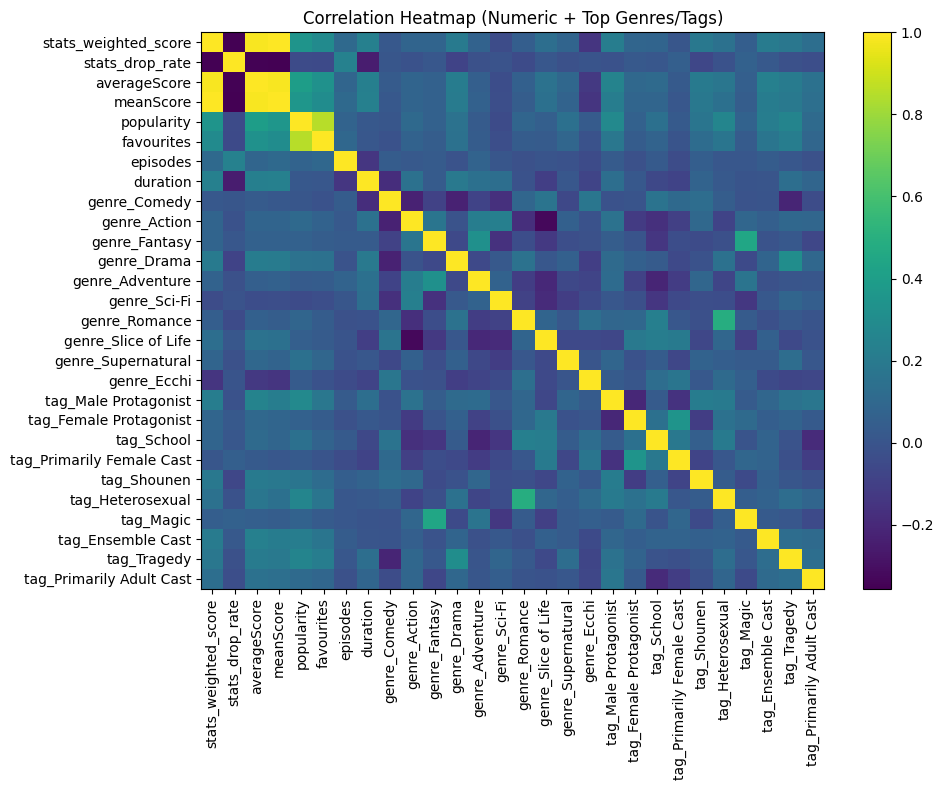

In [137]:
corr = df_final[cols_for_corr].corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.xticks(range(len(cols_for_corr)), cols_for_corr, rotation=90)
plt.yticks(range(len(cols_for_corr)), cols_for_corr)
plt.title("Correlation Heatmap (Numeric + Top Genres/Tags)")
plt.tight_layout()
plt.show()